# Hyperparameters and Model Validation

**Model validation the wrong way**

In [135]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [136]:
# Use a k-nearest neighbors classifier with one neighbor
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [137]:
model.fit(X, y)
y_model = model.predict(X)

In [138]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

**model validation the right way: holdout sets**

In [139]:
from sklearn.cross_validation import train_test_split

In [140]:
# Split the data with 50% in each set. Save as X1, X2, y1, y2.
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                 train_size=0.5)

In [141]:
# Fit the model on the first set of data
model.fit(X1, y1)

# Evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.90666666666666662

**model validation via cross-validation**

In [142]:
# Do a two-fold cross-validation to get two accuracy scores.
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)

accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.95999999999999996, 0.90666666666666662)

In [143]:
# Use scikit-learn's cross_val_score convenience routine to get a fivefold cross-validation.
from sklearn.model_selection import cross_val_score

cross_val_score(model, X, y, cv=5)

array([ 0.96666667,  0.96666667,  0.93333333,  0.93333333,  1.        ])

In [144]:
# Use leave-one-out cross-validation.
from sklearn.model_selection import LeaveOneOut

scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [145]:
# Get the mean of the scores
scores.mean()

0.95999999999999996

## Selecting the best model

**Make a pipeline to string a linear regression combined with a polynomial pre-processor**

In [146]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
# Define PolynomialRegression, with degree default 2, that returns a pipeline with PolynomialFeatures followed by a linear regression.
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [148]:
# Make a function that spits out data we can make a model for
def make_data(N, err=1.0, rseed=1):
    # Randomly sample the data
    rng = np.random.RandomState(rseed)
    X = (rng.rand(N, 1) ** 2)
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

# Save the output of the function with N=40 to X, y
X, y = make_data(40)

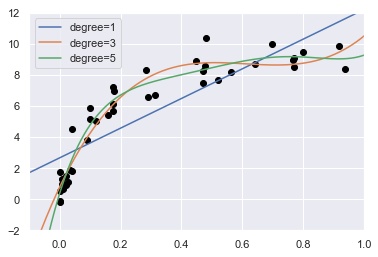

In [149]:
# Make a scatterplot of X vs y.
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, c='black');
axis=plt.axis()

# Generate PolynomialRegression output plots for degree=1, 3, 5
for degree in (1, 3, 5):
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))

# Generate xlim, ylim, and legend
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

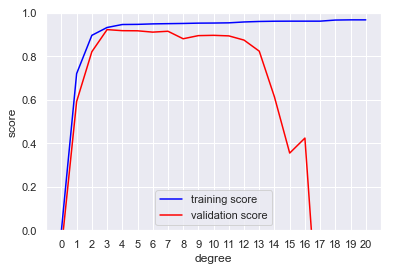

In [150]:
# Grab the validation curve function, use it to figure out how well each of these models performed.
from sklearn.model_selection import validation_curve

degree = np.arange(0, 21)

# Make train_score and val_score, which give the validation curve for the PolynomialRegression function, with X and y as datapoints, cv=7.
train_score, val_score = validation_curve(PolynomialRegression(), X, y, 
                                         'polynomialfeatures__degree', degree, cv=7)

# Plot the degree and median of the training score
plt.plot(degree, np.median(train_score, 1), c='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), c='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xticks(range(21))
plt.xlabel('degree')
plt.ylabel('score');

- Optimal tradeoff is found for a 3rd-order polynomial

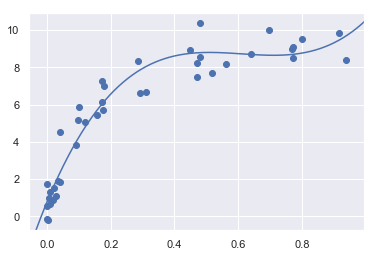

In [151]:
# Plot a third-order polynomial
plt.scatter(X.ravel(), y);
lim = plt.axis();
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

**optimal model depends on size of training data**

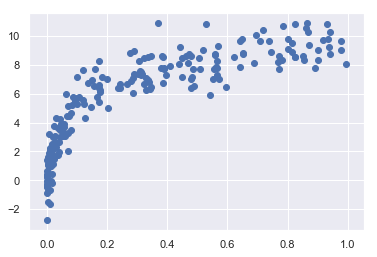

In [152]:
# Generate data, but more of it
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

In [153]:
from sklearn.grid_search import GridSearchCV

In [159]:
# Set up the GridSearchCV meta-estimator
param_grid = dict(polynomialfeatures__degree=np.arange(21), 
                  linearregression__fit_intercept=[True, False], 
                  linearregression__normalize=[True, False])

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [161]:
param_grid

{'linearregression__fit_intercept': [True, False],
 'linearregression__normalize': [True, False],
 'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20])}

In [162]:
# Fit the grid to X and y
grid.fit(X, y)

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [163]:
# Get the best parameters outputted by the GridSearch
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

In [164]:
# Grab the best estimator model
model = grid.best_estimator_

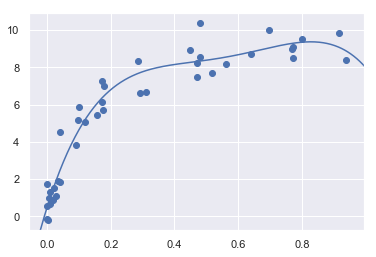

In [173]:
# Plot the best fit model on top of the data
plt.scatter(X.ravel(), y);
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True);
plt.axis(lim);